# NGBoost

NGBoost (Natural Gradient Boosting) is a method for probabilistic regression that extends gradient boosting to predict full probability distributions instead of just point estimates.

**Key Ideas**

- Models the full probability distribution of the target variable, not just a single value.
- For instance, when modeling a normal distribution, NGBoost predicts both the loc (μ) and scale (σ) of the distribution as a target.
- Uses the Natural Gradient to optimize.
- Gradient boosting is a supervised learning method that builds an ensemble of weak learners in a sequential training process.
- NGBoost package: Can be used with any base learner and custom family of distributions with continuous parameters.

**Model documentation**: 

- introduction: https://stanfordmlgroup.github.io/projects/ngboost/
- paper: https://arxiv.org/pdf/1910.03225
- github: https://github.com/stanfordmlgroup/ngboost
- user guide: https://stanfordmlgroup.github.io/ngboost/intro.html
- **guide to add new distribution target and scoring**: https://stanfordmlgroup.github.io/ngboost/5-dev.html

# Probabilistic Forecasting

Probabilistic forecasting provides **a distribution of possible future values** rather than a single point estimate, allowing for uncertainty quantification. Instead of predicting only the most likely outcome, it estimates a range of potential outcomes along with their probabilities by outputting a **probability distribution**.

A probabilistic forecast models the conditional probability distribution of a future value $(Y_t)$ given past observations $(\mathcal{H}_{t-1})$. This can be expressed as:  

$$P(Y_t \mid \mathcal{H}_{t-1})$$

where $(\mathcal{H}_{t-1})$ represents the historical data up to time $(t-1)$. Instead of a single prediction $(\hat{Y}_t)$, the model estimates a full probability distribution $(f(Y_t \mid \mathcal{H}_{t-1}))$, which can take different parametric forms, such as a Gaussian:

$$Y_t \mid \mathcal{H}_{t-1} \sim \mathcal{N}(\mu_t, \sigma_t^2)$$

where $(\mu_t)$ is the predicted mean and $(\sigma_t^2)$ represents the uncertainty in the forecast.

Probabilistic forecasting can be handled through various approaches, including **variance forecasters**, **quantile forecasters**, **interval forecasters** or **distribution forecasters**, each capturing uncertainty differently.

In this notebook, we try to forecast the target location by a gaussian density function (or a mixture), the model output follows the form:

```python
{"density": {
                "name": "normal",
                "params": {"loc": y_mean, "scale": y_var}
            },
                "weight": weight
}
```

A **mixture density**, such as the gaussion mixture $\sum_{i=1}^{K} w_i \mathcal{N}(Y_t | \mu_i, \sigma_i^2)$ allows for capturing multi-modal distributions and approximate more complex distributions.

![proba_forecast_v3](https://github.com/Tarandro/image_broad/blob/main/proba_forecast_v3.png?raw=true)


**Probabilistic Forecasting** is particularly valuable in supply chain management. Below are some interesting resources for a deeper understanding:  

- [Probabilistic Forecasting](https://www.lokad.com/probabilistic-forecasting-definition/) – Overview of probabilistic forecasting and its applications.  
- [Quantile Forecasting](https://www.lokad.com/quantile-regression-time-series-definition/) – Explanation of quantile-based forecasting methods.  
- **Evaluation Metrics:**  
  - [Continuous Ranked Probability Score (CRPS)](https://www.lokad.com/continuous-ranked-probability-score/)  
  - [Cross-Entropy](https://www.lokad.com/cross-entropy-definition/)  
  - [Pinball Loss](https://www.lokad.com/pinball-loss-function-definition/)

In [ ]:
# Requirements
!pip install birdgame ngboost

In [2]:
# Standard library imports
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm

# Birdgame package imports
from birdgame.trackers.trackerbase import TrackerBase
from birdgame import HORIZON
from birdgame.visualization.viz_ngboost import visualize_ngboost

### Warm up example: NGBoost

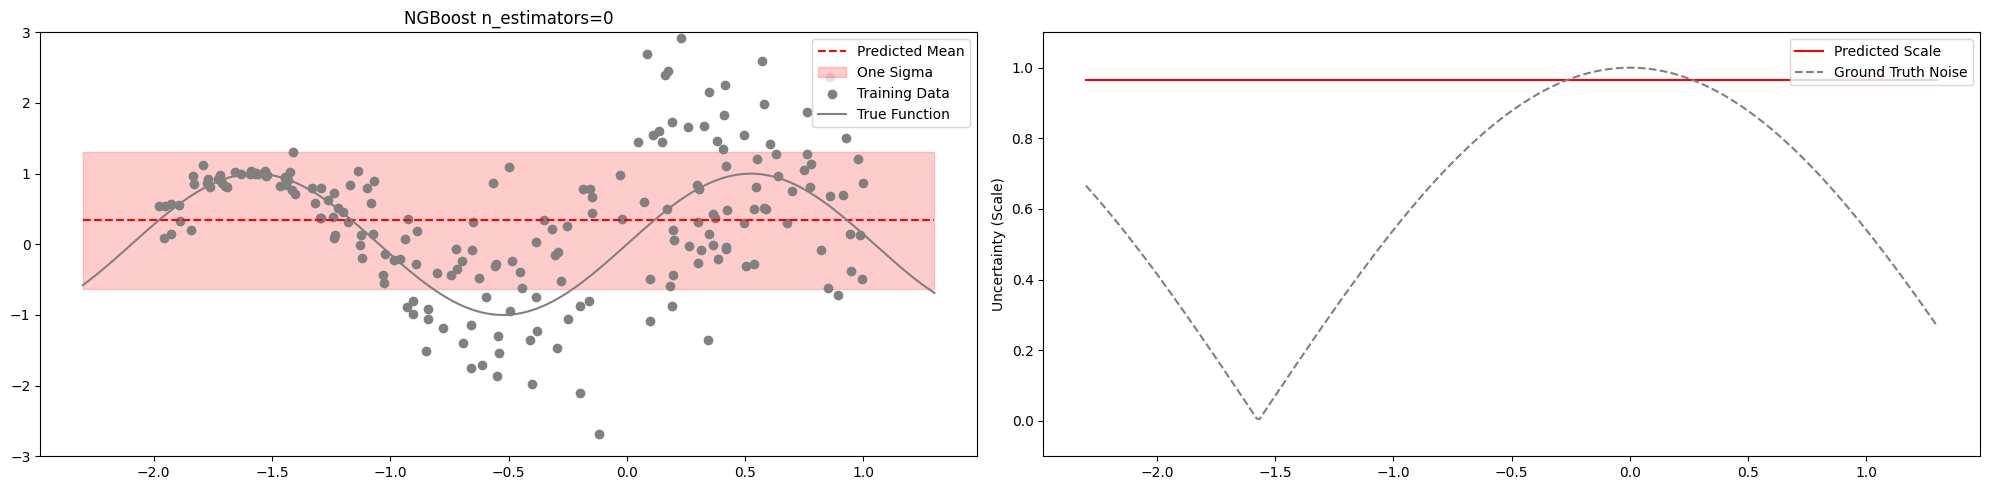

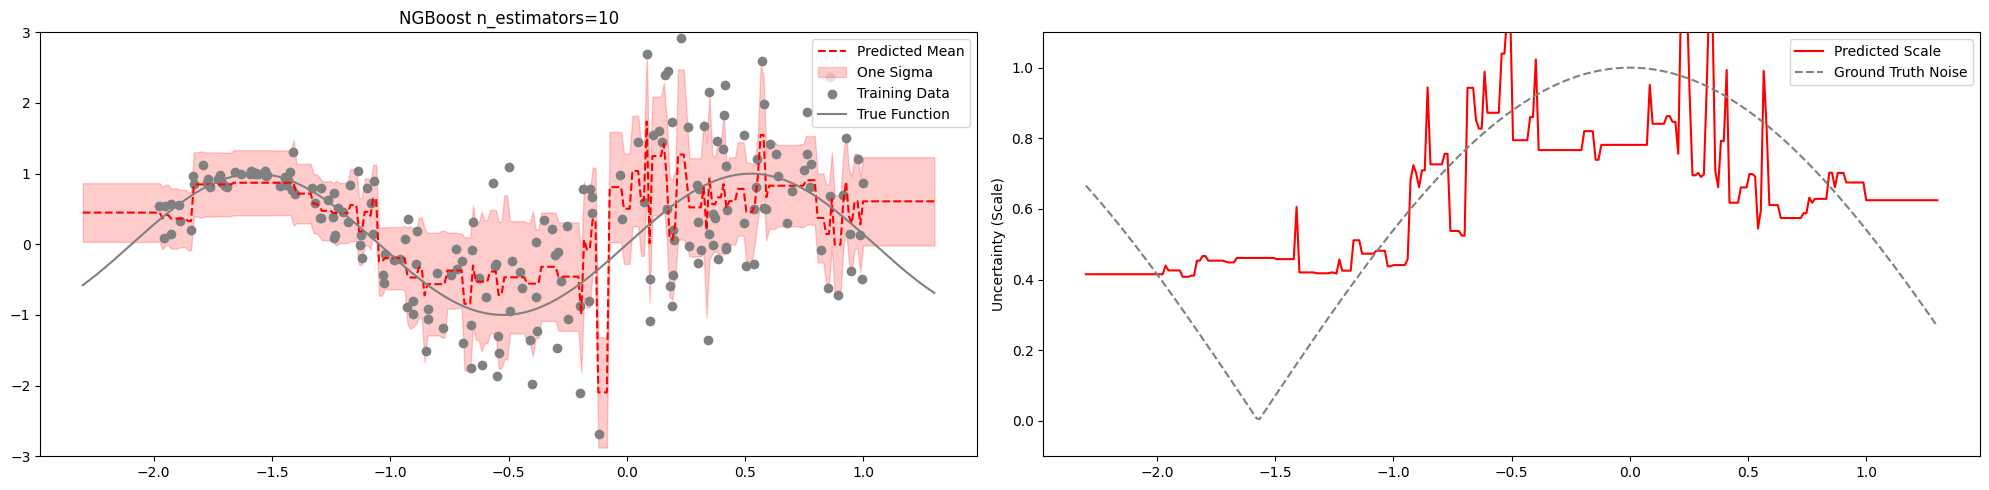

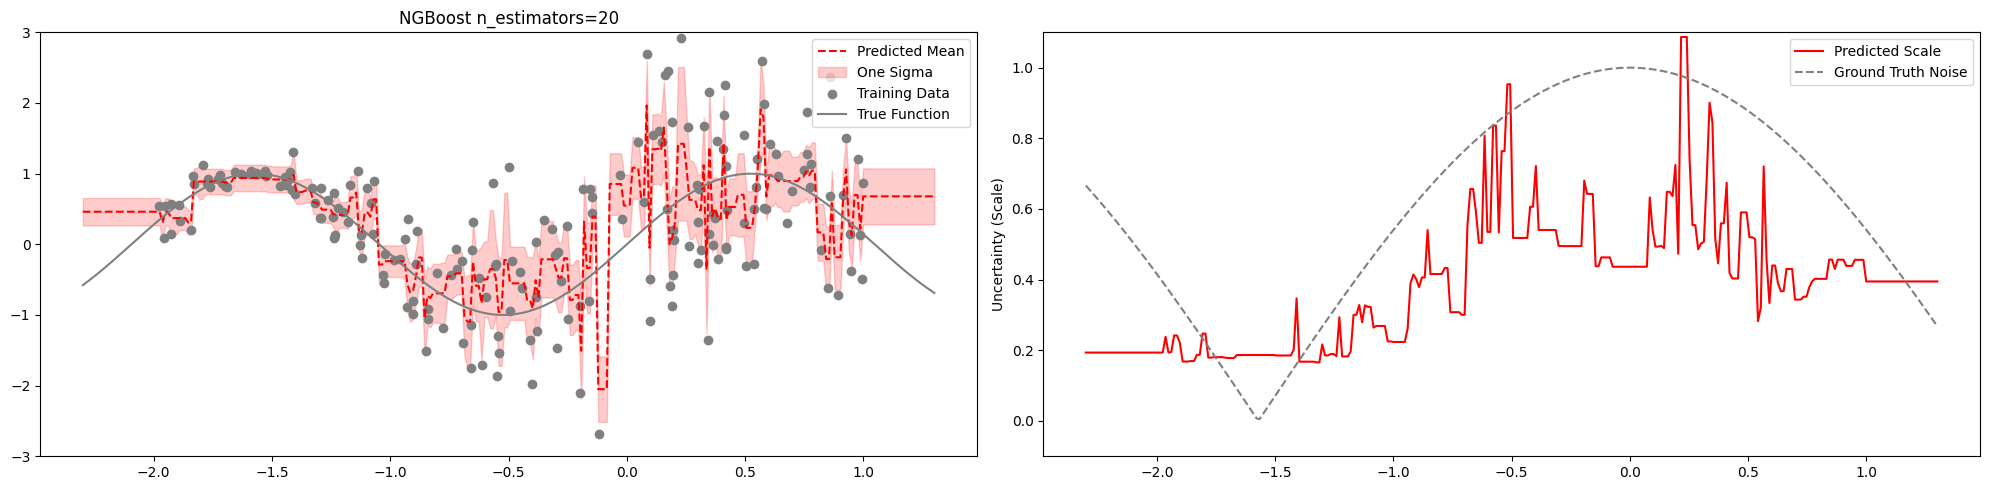

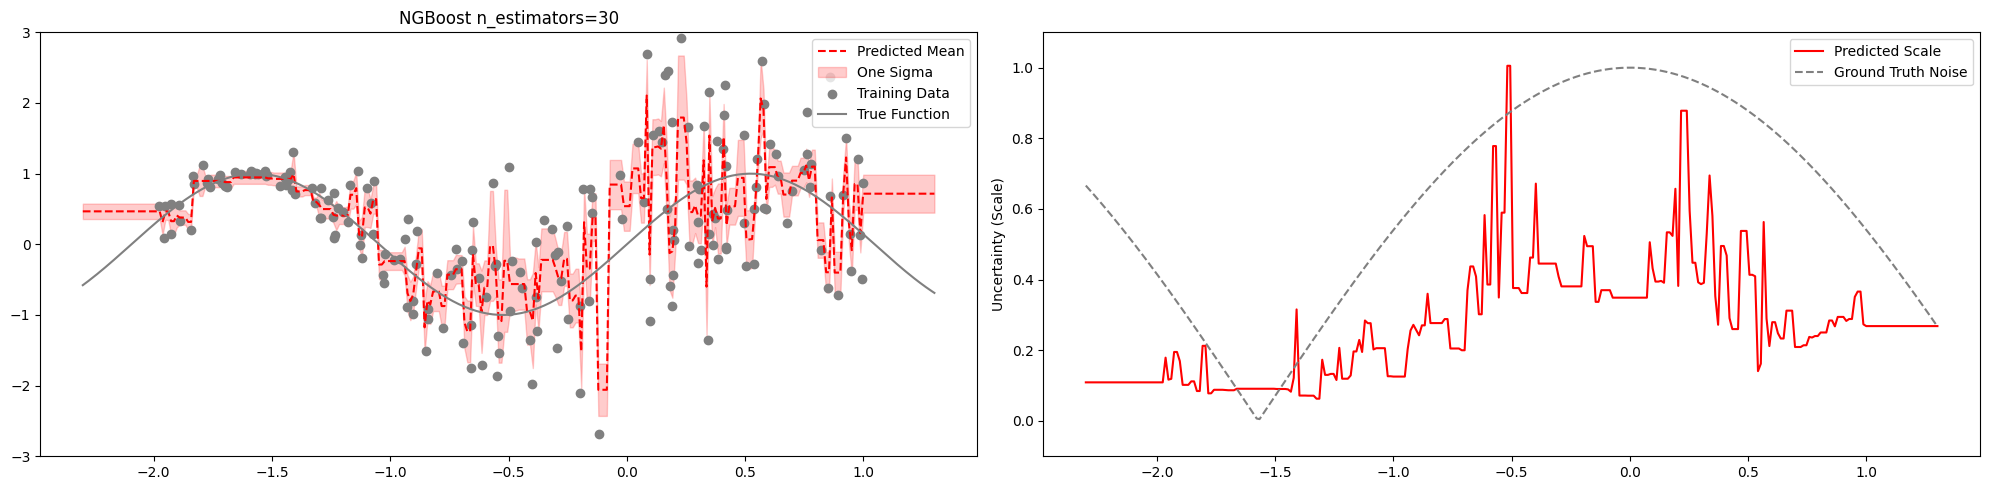

In [3]:
# Run NGBoost for different number of estimators
visualize_ngboost(max_n_estimators=40, step=10, n_data_samples=200)

In [ ]:
import numpy as np
import threading
import time
from ngboost import NGBoost
from ngboost.distns import Normal
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import clone


class NGBoostTracker(TrackerBase):
    """
    A model that tracks the dove location using NGBoost.

    Parameters
    ----------
    A model that tracks the dove location using NGBoost.

    Parameters
    ----------
    horizon : int
        The prediction horizon in seconds (how far into the future predictions should be made).
    train_model_frequency : int
        The frequency at which the NGBoost model will be retrained based on the count of observations 
        ingested. This determines how often the model will be updated with new data.
    num_data_points_max : int
        The maximum number of data points to use for training the NGBoost model.
    window_size : int
        The number of previous data points (the sliding window size) used to predict the future value 
        at the horizon. It defines how many past observations are considered for prediction.
    warmup : int
        The number of ticks taken to warm up the model (wealth does not change during this period).
    use_threading : bool
        Whether to retrain the model asynchronously in a background thread.  
        /!/ Set this to True for live data streams where each `tick()`  
        and `predict()` call must complete within ~50 ms.  
        When enabled, retraining happens in parallel without blocking predictions.
    """

    def __init__(self, horizon=HORIZON):
        super().__init__(horizon)
        self.current_x = None
        self.last_observed_data = [] # Holds the last few observed data points
        self.x_y_data = [] # Holds pairs of previous and current data points

        self.train_model_frequency = Constants.TRAIN_MODEL_FREQUENCY
        self.num_data_points_max = Constants.NUM_DATA_POINTS_MAX # (X.shape[0])
        self.window_size = Constants.WINDOW_SIZE # (X.shape[1])
        self.warmup_cutoff = Constants.WARMUP_CUTOFF
        self.use_threading = Constants.USE_THREADING

        # Initialize NGBoost model
        self.model = NGBoost(
            Dist=Normal,
            learning_rate=0.1,
            n_estimators=50,
            natural_gradient=True,
            verbose=False,
            random_state=15,
            validation_fraction=0.1,
            early_stopping_rounds=None,
            Base=DecisionTreeRegressor(
                criterion="friedman_mse",
                min_samples_split=2,
                min_samples_leaf=1,
                max_depth=5,
                splitter="best",
            ),
        )

        # Internal counters
        self.tick_count = 0

        # Threading tools
        self._lock = threading.Lock()
        if self.use_threading:
            self._cond = threading.Condition(self._lock)
            self._new_data = None
            self._stop_worker = False
            self._worker_thread = threading.Thread(target=self._worker_retrain_model_async, daemon=True)
            self._worker_thread.start()

    # ------------------- Tick -------------------
    def tick(self, payload, performance_metrics=None):
        """
        Ingest a new record (payload), store it internally and update the model.

        Function signature can also look like tick(self, payload) since performance_metrics 
        is an optional parameter.

        Parameters
        ----------
        payload : dict
            Must contain 'time' (int/float) and 'dove_location' (float).
        performance_metrics : dict (is optional)
            Dict containing 'wealth', 'likelihood_ewa', 'recent_likelihood_ewa'.
        """
        # # To see the performance metrics on each tick
        # print(f"performance_metrics: {performance_metrics}")

        # # Can also trigger a warmup by checking if a performance metric drops below a threshold
        # if performance_metrics['recent_likelihood_ewa'] < 1.1:
        #     self.tick_count = 0

        x = payload["dove_location"]
        t = payload["time"]

        self.add_to_quarantine(t, x)
        self.last_observed_data.append(x)
        self.current_x = x
        prev_x = self.pop_from_quarantine(t)

        if prev_x is not None:
            self.x_y_data.append((prev_x, x))

            # retraining condition
            if self.count > self.window_size and self.count % self.train_model_frequency == 0:
                x_y_data = np.array(self.x_y_data)
                xi_values = x_y_data[:, 0]
                yi_values = x_y_data[:, 1]

                # Determine the number of data points to use for training
                num_data_points = min(len(xi_values), self.num_data_points_max)
                if len(xi_values) < self.num_data_points_max + self.window_size:
                    num_data_points = max(0, num_data_points - (self.window_size + 3))

                if num_data_points > self.window_size + 2:
                    # Construct 'X' with fixed-size slices and 'y' as the values to predict
                    X = np.lib.stride_tricks.sliding_window_view(
                        xi_values[-(num_data_points + self.window_size - 1):],
                        self.window_size,
                    )
                    y = yi_values[-num_data_points:]

                    # Fit a single NGBoost model (since we only need one model)
                    if self.use_threading:
                        with self._cond:
                            self._new_data = (X, y)  # overwrite old requests
                            self._cond.notify()
                    else:
                        self._retrain_model_sync(X, y)

                # Keep only latest data (to limit memory usage as it will be run on continuous live data)
                self.x_y_data = self.x_y_data[-(self.num_data_points_max + self.window_size * 2):]
                self.last_observed_data = self.last_observed_data[-(self.window_size + 1):]

            self.count += 1

        self.tick_count += 1

    # ------------------- Prediction -------------------
    def predict(self):
        """
        Return a dictionary representing the best guess of the distribution,
        modeled as a Gaussian distribution.

        If the model is in the warmup period, return None.
        """
        with self._lock:
            # Check if the model is warming up
            if self.tick_count < self.warmup_cutoff:
                return None
            
            start_time = time.perf_counter()

            # the central value (mean) of the gaussian distribution will be represented by the current value
            x_mean = self.current_x
            try:
                X_input = np.array([self.last_observed_data[-self.window_size:]])
                y_test_ngb = self.model.pred_dist(X_input)
                loc = x_mean  # can use y_test_ngb.loc[0] if you prefer model mean
                scale = max(y_test_ngb.scale[0], 1e-6) # get the parameter scale from ngboost normal distribution class
            except Exception:
                loc = x_mean
                scale = 1e-6

            elapsed_ms = (time.perf_counter() - start_time) * 1000  # ms
            # print(f"predict() took {elapsed_ms:.2f} ms")
            if elapsed_ms > 50 and self.use_threading:
                print(f"predict() took {elapsed_ms:.2f} ms")

        # time.sleep(0.01)  # mimic short inference delay

        components = {
            "density": {"type": "builtin", "name": "norm", "params": {"loc": loc, "scale": scale}},
            "weight": 1,
        }
        return {"type": "mixture", "components": [components]}

    # ------------------- Model training -------------------
    def _fit(self, X, y):
        """Train a fresh NGBoost model and return it."""
        if X.shape[0] < 5:
            return self.model  # skip tiny samples

        new_model = clone(self.model)
        new_model.fit(X, y)
        return new_model

    def _retrain_model_sync(self, X, y):
        """Synchronous retraining."""
        start_time = time.perf_counter()
        self.model = self._fit(X, y)
        # print(f"Sync retrain time: {(time.perf_counter()- start_time)*1000:.2f} ms") # check training time

    def _worker_retrain_model_async(self):
        """Asynchronous retraining in a background worker"""
        while True:
            with self._cond:
                # Wait until new data is available
                while self._new_data is None:
                    self._cond.wait()
                X, y = self._new_data  # get the data to train on
                self._new_data = None  # clear it (so next signal is new data)

            # Train the model outside the lock (so predict() can still run)
            new_model = self._fit(X, y)

            # Swap the trained model safely
            with self._lock:
                self.model = new_model
            # print("Async retraining done")


### Tracker experimentation

The model is experimented on a data generator using the [density_pdf](https://github.com/microprediction/densitypdf/blob/main/densitypdf/__init__.py) scoring. For a gaussian distribution, it is:

$$\text{pdf\_score}(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{-\frac{(x - \mu)^2}{2\sigma^2}}$$

This metric measures how well the predicted distribution aligns with the observed data. **A higher pdf_score indicates a more accurate prediction.**

In [5]:
# Parameters
class Constants:
    TRAIN_MODEL_FREQUENCY=100
    NUM_DATA_POINTS_MAX=1000
    WINDOW_SIZE = 5
    WARMUP_CUTOFF = 0
    USE_THREADING=True # Set this to True for live data streams where each `tick()` and `predict()` call must complete within ~50 ms

### Run on a remote static data file

In [28]:
run_on_live_data = False
Constants.USE_THREADING = run_on_live_data
# do not use threading for static data, the stream advances much faster
# than the training process, so asynchronous retraining would lag behind (or use time.sleep())

# Initialize Tracker
tracker = NGBoostTracker()

# Run on remote data
tracker.test_run(live=run_on_live_data)

0it [00:00, ?it/s]

My likelihood score: -2.8327 VS Benchmark likelihood score: 3.5232
     .... and mine is worse. Ratio is -0.80401
My likelihood score: -0.2895 VS Benchmark likelihood score: 3.6554
     .... and mine is worse. Ratio is -0.07919
My likelihood score: 0.4121 VS Benchmark likelihood score: 3.6559
     .... and mine is worse. Ratio is 0.11273
My likelihood score: 0.7108 VS Benchmark likelihood score: 3.6221
     .... and mine is worse. Ratio is 0.19623
Interrupted


### Run on live data

In [6]:
run_on_live_data = True
Constants.USE_THREADING = run_on_live_data


# Initialize Tracker
tracker = NGBoostTracker()

# Run on live data
# Note: the model has a warmup period
tracker.test_run(live=run_on_live_data)
# Interrupt cell to stop run

0it [00:00, ?it/s]

My likelihood score: -19.0306 VS Benchmark likelihood score: -1.1389
     .... and mine is worse. Ratio is 16.71014
My likelihood score: -15.8757 VS Benchmark likelihood score: -0.3140
     .... and mine is worse. Ratio is 50.56644
My likelihood score: -14.7808 VS Benchmark likelihood score: -0.1352
     .... and mine is worse. Ratio is 109.31576
My likelihood score: -13.1629 VS Benchmark likelihood score: 0.0256
     .... and mine is worse. Ratio is -513.96620
Interrupted


### An animated run

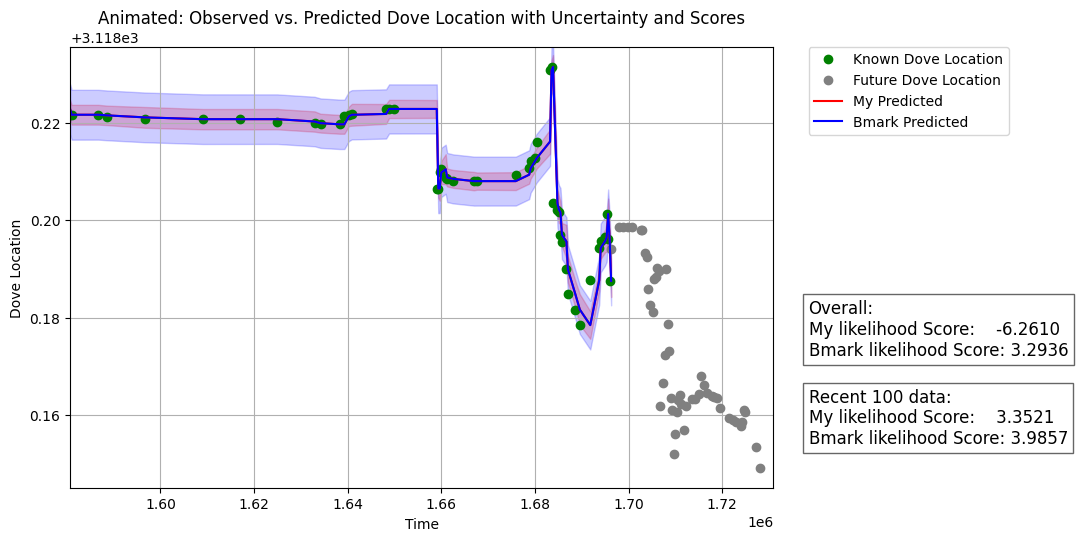


 Run stopped by user.


In [ ]:
%matplotlib inline
from IPython.display import HTML

run_on_live_data = False
Constants.USE_THREADING = run_on_live_data

tracker = NGBoostTracker()

# Note: the model has a warmup period
try:
    animated = tracker.test_run_animated(live=run_on_live_data, from_notebook=True)

    # Display animation in notebook
    HTML(animated.to_jshtml())

except KeyboardInterrupt:
    print("\n Run stopped by user.")
# Interrupt cell to stop run

### Design your own testing process and statistical analysis

In [ ]:
from birdgame.model_benchmark.emwavartracker import EMWAVarTracker
from birdgame.trackers.tracker_evaluator import TrackerEvaluator
from birdgame.datasources.livedata import live_data_generator
from birdgame.datasources.remotetestdata import remote_test_data_generator
from birdgame.visualization.utils import get_loc_and_scale


live = False
Constants.USE_THREADING = live
step_print = 1000
warmup_iterations = 1000
max_iterations = 10000

tracker = NGBoostTracker()

benchmark_tracker = EMWAVarTracker(horizon=tracker.horizon)
my_run, bmark_run = TrackerEvaluator(tracker), TrackerEvaluator(benchmark_tracker)

gen = live_data_generator() if live else remote_test_data_generator()

store_pred = []
try:
    for i, payload in enumerate(tqdm(gen)):

        my_run.tick_and_predict(payload)
        bmark_run.tick_and_predict(payload)

        if i > warmup_iterations:
            score = my_run.scores[-1]
            
            loc, scale = get_loc_and_scale(my_run.latest_valid_prediction)
            store_pred.append({
                "time": my_run.time,
                "prediction": my_run.latest_valid_prediction,
                "loc": loc,
                "scale": scale,
                "dove_location": my_run.dove_location,
                "score": score,
                "log_score": np.log(1e-10 + score)
            })

        if (i + 1) % step_print == 0:
            print(f"My log-likelihood score: {my_run.overall_likelihood_score():.4f} VS Benchmark log-likelihood score: {bmark_run.overall_likelihood_score():.4f}")

        if i > max_iterations:
            break

    print(f"My log-likelihood score: {my_run.overall_likelihood_score():.4f} VS Benchmark log-likelihood score: {bmark_run.overall_likelihood_score():.4f}")
except KeyboardInterrupt:
    print("Interrupted")

0it [00:00, ?it/s]

My likelihood score: -2.8567 VS Benchmark likelihood score: 3.5232
My likelihood score: -0.2847 VS Benchmark likelihood score: 3.6554
My likelihood score: 0.4538 VS Benchmark likelihood score: 3.6559
My likelihood score: 0.7392 VS Benchmark likelihood score: 3.6221
My likelihood score: 1.0662 VS Benchmark likelihood score: 3.6524
My likelihood score: 1.2746 VS Benchmark likelihood score: 3.6755
My likelihood score: 1.3293 VS Benchmark likelihood score: 3.6987
My likelihood score: 1.4530 VS Benchmark likelihood score: 3.6998
My likelihood score: 1.5222 VS Benchmark likelihood score: 3.6989
My likelihood score: 1.6140 VS Benchmark likelihood score: 3.7181
My likelihood score: 1.6147 VS Benchmark likelihood score: 3.7182


In [11]:
from birdgame.visualization.utils import summarize_predictions
stats_summary, pred_summary = summarize_predictions(store_pred, skip_length=0)

Mean: {'score': 100.642, 'log_score': 2.029}
Median: {'score': 105.103, 'log_score': 4.655}
Std: {'score': 75.137, 'log_score': 6.835}

Prediction Data:


,time,prediction,loc,scale,dove_location,score,log_score
0,1.341040e+06,"{'type': 'mixture', 'components': [{'density':...",3118.13669,0.00110,3118.13391,14.71506,2.68887
1,1.341358e+06,"{'type': 'mixture', 'components': [{'density':...",3118.13391,0.00166,3118.13986,0.38722,-0.94877
2,1.341676e+06,"{'type': 'mixture', 'components': [{'density':...",3118.13986,0.00280,3118.13945,141.13378,4.94971
3,1.341994e+06,"{'type': 'mixture', 'components': [{'density':...",3118.13945,0.00172,3118.13908,225.87541,5.41998
4,1.342313e+06,"{'type': 'mixture', 'components': [{'density':...",3118.13908,0.00216,3118.14338,25.37452,3.23375
...,...,...,...,...,...,...,...
9696,2.499337e+07,"{'type': 'mixture', 'components': [{'density':...",3118.07078,0.00218,3118.07124,178.98094,5.18728
9697,2.499910e+07,"{'type': 'mixture', 'components': [{'density':...",3118.07124,0.00196,3118.07124,203.91824,5.31772
9698,2.500770e+07,"{'type': 'mixture', 'components': [{'density':...",3118.07124,0.00188,3118.07124,212.21249,5.35759
9699,2.500929e+07,"{'type': 'mixture', 'components': [{'density':...",3118.07124,0.00197,3118.07238,171.26523,5.14321


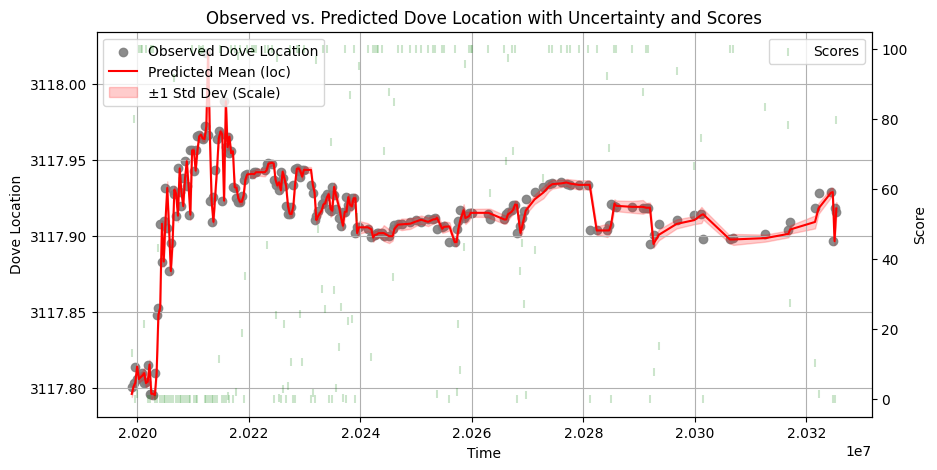

In [12]:
from birdgame.visualization.viz_predictions import plot_dove_predictions
start_ind=8000
window_size=200
plot_dove_predictions(store_pred, start_ind, window_size)